# Use Case Example: Photometry

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (11, 10)

## Where's my stuff? (For this notebook only) 

In [4]:
import os
baseDir    = os.getenv("PLATO_PROJECT_HOME")
currentDir = os.getcwd()

import sys
sys.path.append(baseDir + "/python")

## Import the relevant modules

In [5]:
from numpy import *
from scipy import optimize
from scipy.stats import binned_statistic
import matplotlib.cm as cm
import h5py
from simfile import SimFile
from simulation import Simulation
import referenceFrames as ref
import platophot as phot
import transits
import noise

## Make a proper input yaml file

I'm only showing some relevant fields of the inputfgs.yaml file. We want to simulate a little more than 1 week of continuous observations with a nominal camera.

General:
    
    ProjectLocation:             ENV['PLATO_PROJECT_HOME']

ObservingParameters:

    NumExposures:                25000 
    ExposureTime:                23 
    RApointing:                  180
    DecPointing:                 -70 
    StarCatalogFile:             inputfiles/starcatalog.txt

Platform:

    UseJitter:                   no   

Telescope:

    AzimuthAngle:                0.0     
    TiltAngle:                   0.0     
    UseDrift:                    no

PSF:

    Model:                       FromFile
      Filename:                  inputfiles/psf.hdf5 
      DistanceToOA:              -1           
      RotationAngle:             -1          
      NumberOfPixels:            8    
      
CCD:      
  
    IncludeFlatfield:            no 
    IncludePhotonNoise:          yes 
    IncludeReadoutNoise:         yes 
    IncludeCTIeffects:           no  
    IncludeOpenShutterSmearing:  no 
    IncludeVignetting:           no 
    IncludeConvolution:          yes
    IncludeFullWellSaturation:   yes 
    IncludeDigitalSaturation:    yes  
    WriteSubPixelImagesToHDF5:   no 
      
      
SubField:    

    NumColumns:                  150  
    NumRows:                     150  
    SubPixels:                   32 


## Run PlatoSim

In [538]:
simulation = Simulation("photometrySimulation", "inputphot.yaml")
simulation["ObservingParameters/NumExposures"] = 25000
simulation.outputDir = currentDir
myRun = simulation.run()

In [19]:
%ls -lh PhotometrySimulation.hdf5

-rw-r--r--  1 joris  206   3.4G Jun  9 02:44 PhotometrySimulation.hdf5


In principle, you can continue from simFile and continue exploiting its contents. In this example, we will split up the post-processing for the sake of clarity.

## Show an example subfield

In [6]:
sim = SimFile("photometrySimulation.hdf5")

In [7]:
image = sim.getImage(0)

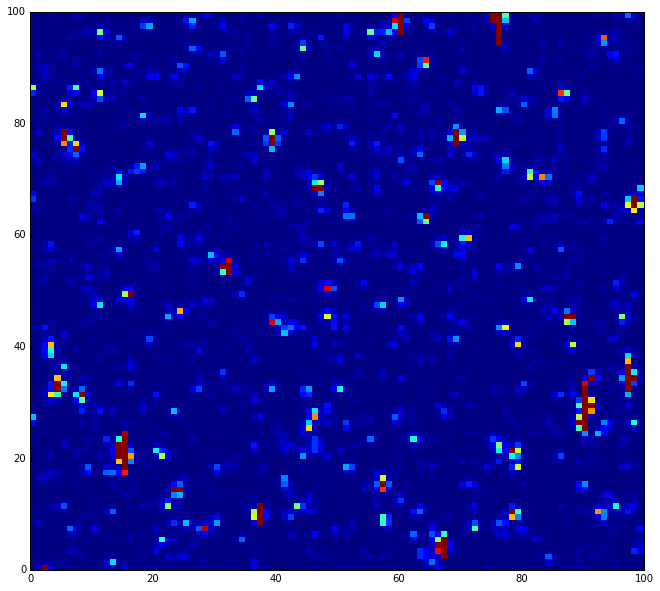

In [8]:
plt.pcolormesh(image, cmap=cm.jet)

This field contains more than 1700 stars that were tracked!

## Plot the positions of stars brighter than V=13 on top

Find out which stars bright

In [11]:
allStarIDs, RA, dec, Vmag, xFPmm, yFPmm, rowPix, colPix = sim.getStarCatalog()
brightStarIDs = allStarIDs[Vmag < 13.0]
print("Number of bright stars: {0}".format(len(brightStarIDs)))

Number of bright stars: 372


Get all starIDs that are on image nr. 0. Note that these IDs are not necessarily the same as 'allStarIDs'. The latter contains all stars that have been detected, even if only in a few images because the star jittered in the subfield.

In [12]:
starIDsInImage0, row, col, Xmm, Ymm = sim.getStarCoordinates(0)

Get the array indices of the bright stars in the 'starIDsInImage0' array. This requires a numpy trick.

In [13]:
brightStarIndices = arange(len(starIDsInImage0))[in1d(starIDsInImage0, brightStarIDs)]

Now we can extract the row and column values of the bright stars:

In [14]:
rowBrightStars = row[brightStarIndices]
colBrightStars = col[brightStarIndices]

Over-plot these row and column coordinates 

(0, 100)

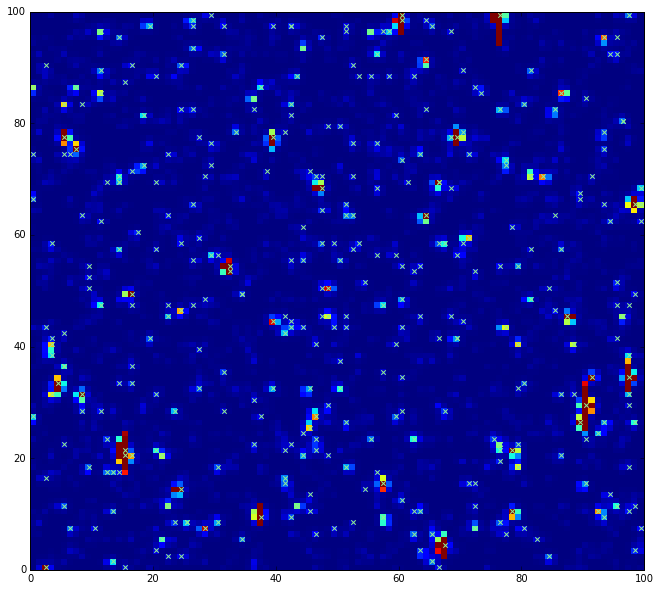

In [20]:
plt.pcolormesh(image, cmap=cm.jet)
plt.scatter(floor(colBrightStars)+0.5, floor(rowBrightStars)+0.5, marker='x', c='lightgreen')
plt.xlim(0,100)
plt.ylim(0,100)

## Weighted photometry

We assume that each pixel value $f_{ij}$ is composed of a signal $s_{ij}$, a background $b_{ij}$, and noise $\epsilon_{ij}$:  

$$ f_{ij} = s_{ij} + b_{ij} + \varepsilon_{ij}$$

The background $b_{ij}$ is assumed to be known (in practice: read from the HDF5 file), and subtracted first. The total flux of a star is then computed using a weighted sum:

$$ F \equiv \sum\limits_{ij} \alpha \ w_{ij} (f_{ij} - b_{ij}) $$

where the weights are exponentially decaying:

$$w_{ij} = \exp\left(-\frac{(i-i_0)^2 + (j-j_0)^2}{2\sigma^2_{psf}}\right)$$

The exact (fractional) pixel coordinates $(i_0, j_0)$ of the star will be known using the Gaia catalog. For now, they are assumed to be known (i.e. read from the HDF5 file) as well.

## Figure out the width of the PSF

In [21]:
outputFile = h5py.File("photometrySimulation.hdf5")

In [22]:
psf = array(outputFile["/PSF/rebinnedPSFsubPixel"])
NsubPixels = outputFile["/InputParameters/SubField"].attrs["SubPixels"]
Npixels = int(psf.shape[0]/NsubPixels)
print("PSF consists of {0}x{0} pixels, with each pixel made up of {1}x{1} subpixels".format(Npixels, NsubPixels))

PSF consists of 8x8 pixels, with each pixel made up of 32x32 subpixels


Plot the PSF to see what we're dealing with.

(0, 256)

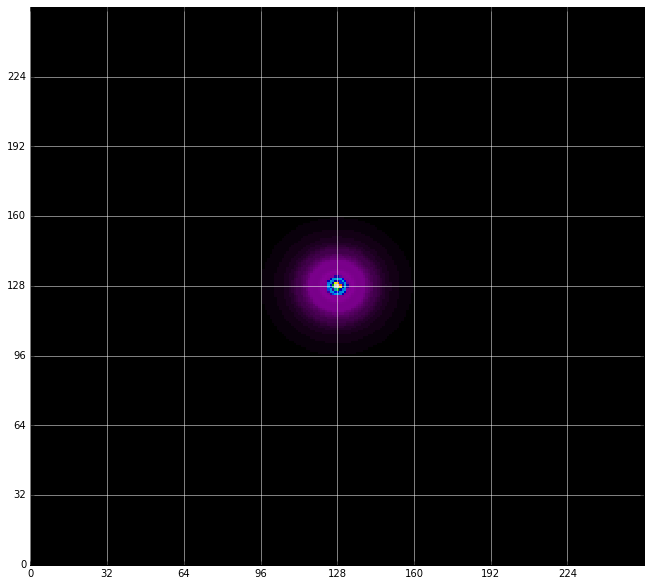

In [23]:
plt.pcolormesh(psf, cmap=cm.spectral, vmax=0.01)                         # 'vmax' to get a prettier image
plt.grid(True, which='major', axis='both', linestyle='-', color='w')     # To get a 'pixel-grid' on top of it.
plt.xticks(arange(0, psf.shape[0], NsubPixels))
plt.yticks(arange(0, psf.shape[1], NsubPixels))
plt.xlim(0, psf.shape[0])
plt.ylim(0, psf.shape[1])

In [24]:
sigmaPSF = phot.computePSFsigma(psf, NsubPixels)
print("Standard deviation of the PSF (assuming symmetry): {0}".format(sigmaPSF))

Standard deviation of the PSF (assuming symmetry): 0.44405378844375376


The following function extracts the flux of all stars in every image in the HDF5 simulation output file, and writes the results to a second HDF5 file. Depending on the number of exposures, this can take a while.

In [25]:
phot.photometry("photometrySimulation.hdf5", "photometryOutput.hdf5", sigmaPSF)

What did the photometry script do?
- Estimate the bias and subtract it
- Correct for open shutter smearing using the smearing maps
- Convert from [ADU] to [electrons] using the gain
- Correct for the flatfield
- Subtract the background (assumed to be known)
- Do the weighted mask photometry, assuming the correct star positions

In [114]:
%ls -lh photometryOutput.hdf5

-rw-r--r--  1 joris  206   2.2G Jun  9 08:06 photometryOutput.hdf5


### What does a photometry output HDF5 file look like?

In [26]:
photFile = h5py.File("photometryOutput.hdf5")

In [504]:
for group in photFile["/"]:
    print(group)

Photometry


In [506]:
for group in photFile["/Photometry"]:
    print(group)

Exposure000000
Exposure000001
Exposure000002
Exposure000003
Exposure000004
Exposure000005
Exposure000006
Exposure000007
Exposure000008
Exposure000009
Exposure000010
Exposure000011
Exposure000012
Exposure000013
Exposure000014
Exposure000015
Exposure000016
Exposure000017
Exposure000018
Exposure000019
Exposure000020
Exposure000021
Exposure000022
Exposure000023
Exposure000024
Exposure000025
Exposure000026
Exposure000027
Exposure000028
Exposure000029
Exposure000030
Exposure000031
Exposure000032
Exposure000033
Exposure000034
Exposure000035
Exposure000036
Exposure000037
Exposure000038
Exposure000039
Exposure000040
Exposure000041
Exposure000042
Exposure000043
Exposure000044
Exposure000045
Exposure000046
Exposure000047
Exposure000048
Exposure000049
Exposure000050
Exposure000051
Exposure000052
Exposure000053
Exposure000054
Exposure000055
Exposure000056
Exposure000057
Exposure000058
Exposure000059
Exposure000060
Exposure000061
Exposure000062
Exposure000063
Exposure000064
Exposure000065
Exposure00

In [508]:
for dataset in photFile["/Photometry/Exposure000000"]:
    print(dataset)

SNR
Vmag
estimatedFlux
inputFlux
maskSize
starID
varEstimatedFlux


Get the photometry done on the very first image. Fluxes are expressed in [electrons/exposure]

In [338]:
starID           = array(photFile["/Photometry/Exposure000000/starID"])
inputFlux        = array(photFile["/Photometry/Exposure000000/inputFlux"])
estimatedFlux    = array(photFile["/Photometry/Exposure000000/estimatedFlux"])
varEstimatedFlux = array(photFile["/Photometry/Exposure000000/varEstimatedFlux"])
Vmag             = array(photFile["/Photometry/Exposure000000/Vmag"])
SNR              = array(photFile["/Photometry/Exposure000000/SNR"])
maskSize         = array(photFile["/Photometry/Exposure000000/maskSize"]) 

The theoretical photon noise limit is not saved in HDF5 but is easily computable using the 'inputFlux'. If we sort the photon noise value, we can plot them in one smooth line. Note the 'inputFlux' stored in the HDF5 file is an electron flux, already taking into account the transmission efficiency, and the QE. 

In [371]:
photonLimit = inputFlux/sqrt(inputFlux)
sorted = argsort(photonLimit)[::-1]

Plot the Signal-to-Noise ratio (per exposure) of all stars in the subfield, together with theoretical photon noise limit.

(0, 1600)

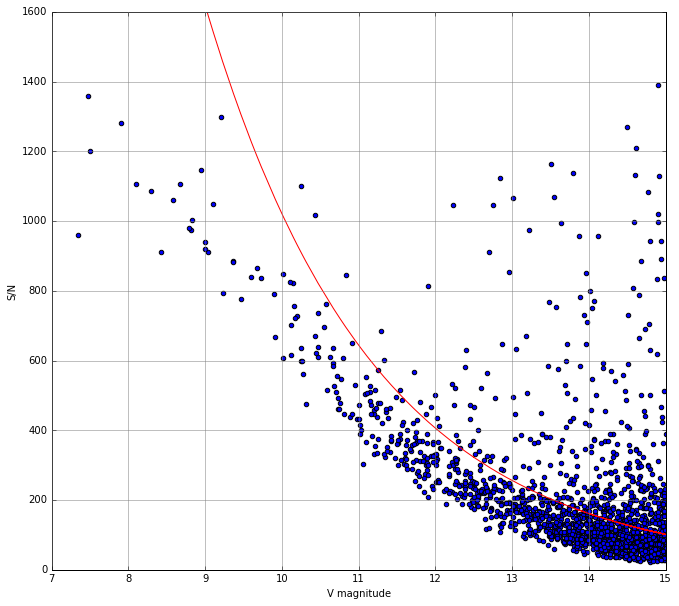

In [373]:
plt.scatter(Vmag, SNR)
plt.plot(Vmag[sorted], photonLimit[sorted], c="r")
plt.grid(True, which='major', axis='both', linestyle='-', color='gray')
plt.xlabel("V magnitude")
plt.ylabel("S/N")
plt.xlim(7,15)
plt.ylim(0,1600)

The large S/N values at the faint end are caused by nearby brighter stars that significantly contaminate the flux level. Even for lower magnitudes, the S/N ratio is well below the photon noise limit because of the weighted photometry gives a lower weight to the tails of the PSF. You can of course play with the PSF-width you feed to phot.photometr(), to verify if it gives better results. For the very brightest stars, the electrons flowing away due to blooming are not recovered when extracting the stellar flux.

## Extract the time series of one particular star

We choose one particular 11th magnitude star

In [27]:
myStarID = 9789

In [92]:
time, flux = phot.getPhotometryTimeSeries("photometryOutput.hdf5", myStarID)

Convert the absolute flux [electrons/exposure] into a relative flux [ppm]

In [93]:
relativeFlux = (flux - flux.mean())/flux.mean()*1.e6 

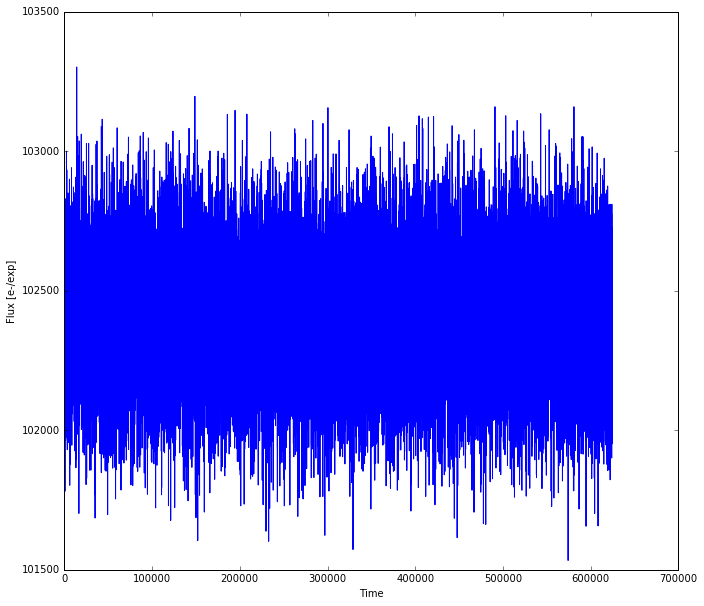

In [96]:
plt.plot(time, flux)
plt.xlabel("Time")
plt.ylabel("Flux [e-/exp]")

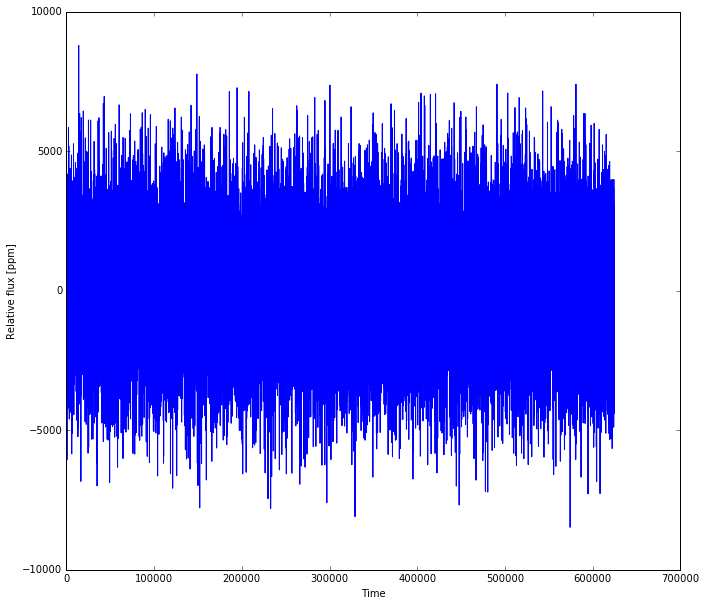

In [98]:
plt.plot(time, relativeFlux)
plt.xlabel("Time")
plt.ylabel("Relative flux [ppm]")

## Generate stellar granulation

In [99]:
time =  array(outputFile["/StarPositions/Time"])

In [100]:
timeScale = array([2060.0])       # sec
varScale  = array([520.0])        # ppm

More decent values for Sun-like stars can be obtained from Pallé, P.L., Roca-Cortés, T., & Jimenez, A. 1999, ASP
Conf. Ser. 173, Stellar Structure: Theory and Test of Convective Energy Transport, ed. A. Gimenez, E.F. Guinan, &
B. Montesinos, 297.

In [101]:
granulation = noise.redNoise(time, timeScale, varScale) 

Simulating 1 component(s)
Kicktimestep = 20.6
Warming up...
Simulating red noise component(s)


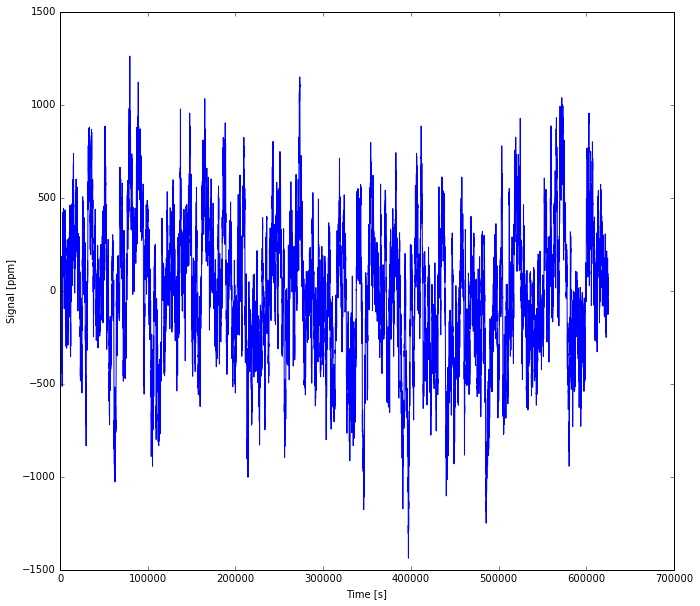

In [102]:
plt.plot(time, granulation)
plt.xlabel("Time [s]")
plt.ylabel("Signal [ppm]")

## Generate an exoplanet signature

In [103]:
import transits

In [104]:
t0 = 5 * 3600.
flatPartDuration = 3 * 3600.
transitDuration  = 4 * 3600.
orbitalPeriod    = 36 * 3600.
relativeDepth    = 0.001         # 1000 ppm
phase, signal = transits.simpleTransit(time, t0, flatPartDuration, transitDuration, orbitalPeriod, relativeDepth)

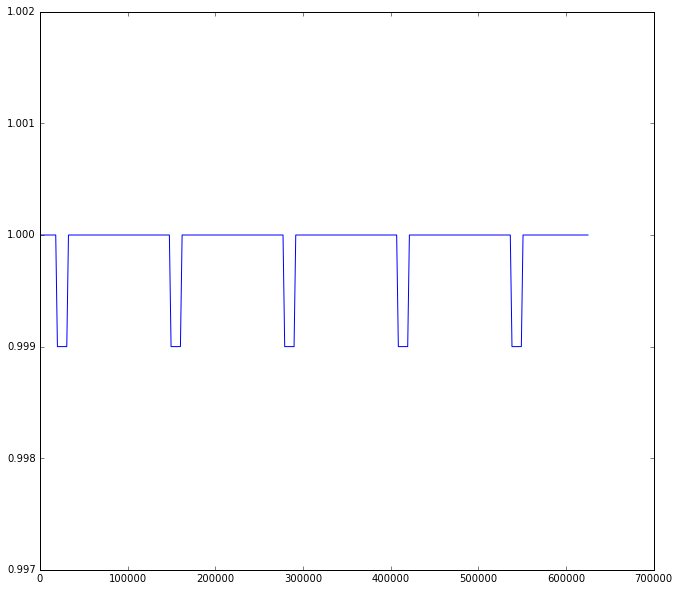

In [105]:
plt.plot(time, signal)
plt.ylim(0.997, 1.002)
plt.ticklabel_format(style='plain', axis='y', useOffset=False)

## Combine everything

In [106]:
flux *= signal
relativeFlux = (flux - flux.mean())/flux.mean()*1.e6     # ppm
relativeFlux += granulation

Bin the time series to make the structure inside more clear

In [107]:
binnedMean, binEdges, binNumber = binned_statistic(time, relativeFlux, statistic='mean', bins=100)
binCenters = (binEdges[1:] + binEdges[:-1])/2.0

Now plot the original time series as well as the binned time series.

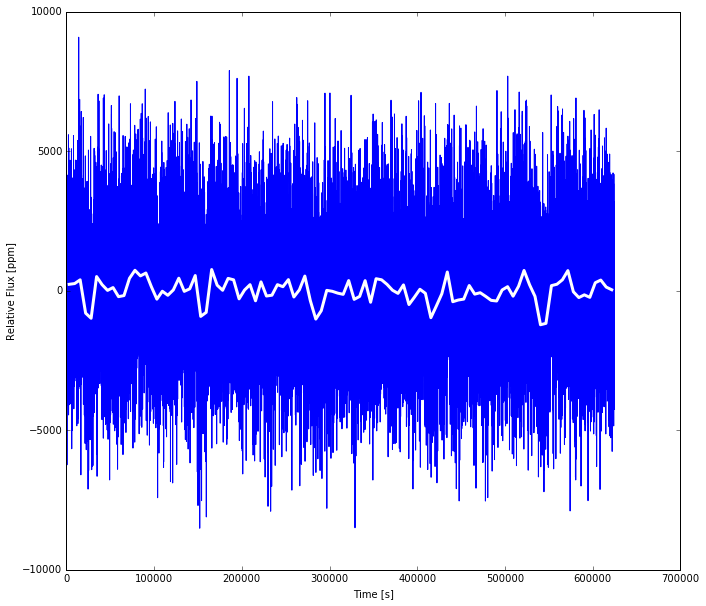

In [108]:
plt.plot(time, relativeFlux, c='b')
plt.plot(binCenters, binnedMean, c='w', linewidth=3)
plt.xlabel("Time [s]")
plt.ylabel("Relative Flux [ppm]")

## Plot the power spectral density of the time series

In [109]:
def FFTpowerdensity(signal, timestep):

    fourier = fft.rfft(signal)
    Ntime = len(signal)
    Nfreq = len(fourier)
  
    powerdensity = abs(fourier)**2 / Ntime * timestep
    freq = arange(float(Nfreq)) / (Nfreq-1) * 0.5 / timestep
  
    return (freq, powerdensity)

In [110]:
freq, psd = FFTpowerdensity(relativeFlux, (time[1]-time[0])*1.e-6)

The 1.e-6 is to convert the time unit from [s] to [Ms], so that the frequency is in [microHz].

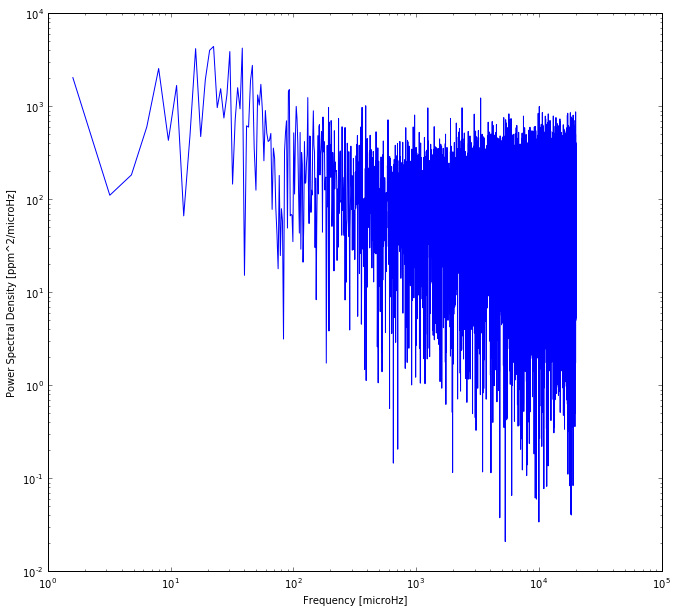

In [111]:
plt.loglog(freq, psd)
plt.xlabel("Frequency [microHz]")
plt.ylabel("Power Spectral Density [ppm^2/microHz]")